<h2>Script TP2</h2>
<h3>Assumptions Check</h3>
<h3>Path analysis</h3>
<br> (c) Marie-Eve Picard, Maude Picard, Andreanne Proulx


Contacter Émilie Dessurault pour Brain Hack

<h3>Assumptions Check</h3>
<h4>Normality, multicollinearity, singularity</h4>

In [1]:
#import required modules
import pandas as pd 
import numpy as np
import scipy
import scipy.stats as stats
import math
import matplotlib
from matplotlib import pyplot as plt 
%matplotlib inline
import seaborn as sn
import statsmodels.api as sm
from sklearn import preprocessing

In [2]:
#set pandas option so that we can see the entire dataframe
pd.set_option("display.max_rows", None, "display.max_columns", None)

<b>Import the dataset</b>

In [3]:
#Value labels have been remove directly from SPSS using the syntaxe:
#VALUE LABELS ALL

In [66]:
df = pd.read_spss("C:/Users/mepic/OneDrive/Documents/Master/PSY6002/TP/TP2/PSY6002_Cannabis_removeLabels.sav")

In [67]:
#Variables to exclude
ls_excluded = ['respid','status','l','version','dwave','Consent','XAge','Birth','XBirth','Mom_Nat','XMom_Nat', 'Pop_Nat', 'XPop_Nat', 'Country', 'Province','City','XCity','Language','XLanguage','French','English','Nationality','CanNat','OtherNat','Can_Qc','Diploma','Situation','FinalComments','ConsentT2','FinalCommentsT2','ConsentT3','FinalCommentT3','oldq1','oldl','oldhq2','oldq9','oldCountryBirth','oldMotherBirth','oldDadBirth','oldCountry','oleProvince','OldNationality','oleDiploma','oldq11','IdenGroupT2','oldAge', 'IdenGroupT3']
df = df.drop(ls_excluded, axis = 1)

In [68]:
#Regroup variables with a spectific substring in the name
def regroupVar(substr=None, liste=None):
    subs = substr
    res = [i for i in liste if subs in i]
    return res


columns_T2 = regroupVar(substr = 'T2', liste = df.columns)
columns_T3 = regroupVar(substr = 'T3', liste = df.columns)

In [69]:
#Create new Dataframes with variables at different times (T1, T2, T3)
df_T1 = df.drop(columns_T2+columns_T3, axis = 1)
df_T2 = df.filter(items = columns_T2)
df_T3 = df.filter(items = columns_T3)

In [70]:
df_T1.columns

Index(['Gender', 'Age', 'life_cond', 'left_right', 'change_trad', 'Freqnow',
       'Userstatus', 'Legal', 'Illegal', 'Quantity', 'Frequency', 'Attitude_2',
       'Attitude_3', 'Attitude_4', 'GQuantity', 'GFrequency', 'Neg_Pos',
       'AffectPerso', 'AffectGroup', 'Rapid_slow', 'Few_Many', 'Small_Big',
       'Comp_1', 'Comp_2', 'Cat', 'Int_2', 'Int_3', 'Int_4', 'IdentifyPot',
       'CommonPot', 'ImpPot', 'Moi_Pot', 'GComp_1', 'GComp_2', 'GCat',
       'GInt_2', 'GInt_3', 'GInt_4', 'GIdentifyPot', 'GcommonPot', 'GImpPot',
       'Can_Pot', 'Qc_Pot', 'SuiviPot', 'Clarity_2', 'Clarity_3',
       'Coherence_1', 'Coherence_3', 'Coherence_4', 'Belong_1', 'Belong_2',
       'Belong_3', 'Safety_1', 'Safety_2', 'Safety_3', 'Comp', 'GComp',
       'IdenPot', 'GIdenPot', 'Attitudes', 'Int', 'GInt', 'Clarity',
       'Coherence', 'Belong', 'Safety'],
      dtype='object')

<h3><b>Transform Userstatus variable in a dichotomous variable</h3></b>
0 = jamais consommé (category included: Non-consommateur)
<br>1 = déjà consommé (categories included: Ex-consommateur, Expérimentateur, Occasionnel, Régulier)

In [71]:
df_T1['UserBin'] = ""
for i in range(len(df_T1['Userstatus'])):
    if df_T1['Userstatus'][i] == 1.0:
        df_T1['UserBin'][i] = 0
    else:
        df_T1['UserBin'][i] = 1

df_T1['UserBin'] = df_T1['UserBin'].astype('category')

<ipython-input-71-361c70e085d1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_T1['UserBin'][i] = 0
<ipython-input-71-361c70e085d1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_T1['UserBin'][i] = 1


<h3><b>Compute variables</h3></b>

<b>Compute the Attitude variable (T1)</b>
<br>reverse attitude items and compute the mean

In [72]:
#Create dataframe with only variables from prejudice scale
att_scale_T1 = df_T1.filter(items = ['Attitude_2','Attitude_3','Attitude_4'])

In [73]:
#Create a function to reverse the score
def inversed_score(dataframe = None, high = None):
    dataframe_dummy = dataframe.copy()
    for i in range(len(dataframe_dummy.columns)):
        for j in range (len(dataframe_dummy[dataframe_dummy.columns[0]])):
            dataframe_dummy[dataframe_dummy.columns[i]][j] = high - dataframe_dummy[dataframe_dummy.columns[i]][j]

    return dataframe_dummy

In [74]:
#Reverse Echelle de prejuges
att_scale_T1_inversed = inversed_score(dataframe = att_scale_T1, high = 4)

In [75]:
#Calculate the mean of items in Echelle de prejuges (items 19 a 22)
df_T1["att_mean"] = att_scale_T1_inversed.mean(axis=1, skipna=False)

In [76]:
def compute_mean(dataframe=None, cols = None, col_name = None):
    dataframe[col_name] = dataframe[cols].mean(axis = 1)

    return dataframe

In [77]:
#Compute perception du changement social (items 27,28,29,29)
df_T1 = compute_mean(dataframe = df_T1, cols = ['AffectGroup', 'Rapid_slow', 'Few_Many', 'Small_Big'], col_name = 'perc_soc')
#Compute clarity and coherence (items 46 a 52)
df_T1 = compute_mean(dataframe = df_T1, cols = ['Clarity','Coherence'], col_name = 'clar_co')
#Compute Besoin (items 53  a 60)
df_T1 = compute_mean(dataframe = df_T1, cols = ['Belong','Safety'], col_name = 'need')

In [78]:
#Compute perception (items 23, 24)
df_T1 = compute_mean(dataframe = df_T1, cols = ['GQuantity', 'GFrequency'], col_name = 'percep')

In [79]:
df_T1.columns

Index(['Gender', 'Age', 'life_cond', 'left_right', 'change_trad', 'Freqnow',
       'Userstatus', 'Legal', 'Illegal', 'Quantity', 'Frequency', 'Attitude_2',
       'Attitude_3', 'Attitude_4', 'GQuantity', 'GFrequency', 'Neg_Pos',
       'AffectPerso', 'AffectGroup', 'Rapid_slow', 'Few_Many', 'Small_Big',
       'Comp_1', 'Comp_2', 'Cat', 'Int_2', 'Int_3', 'Int_4', 'IdentifyPot',
       'CommonPot', 'ImpPot', 'Moi_Pot', 'GComp_1', 'GComp_2', 'GCat',
       'GInt_2', 'GInt_3', 'GInt_4', 'GIdentifyPot', 'GcommonPot', 'GImpPot',
       'Can_Pot', 'Qc_Pot', 'SuiviPot', 'Clarity_2', 'Clarity_3',
       'Coherence_1', 'Coherence_3', 'Coherence_4', 'Belong_1', 'Belong_2',
       'Belong_3', 'Safety_1', 'Safety_2', 'Safety_3', 'Comp', 'GComp',
       'IdenPot', 'GIdenPot', 'Attitudes', 'Int', 'GInt', 'Clarity',
       'Coherence', 'Belong', 'Safety', 'UserBin', 'att_mean', 'perc_soc',
       'clar_co', 'need', 'percep'],
      dtype='object')

<b>Create a dataframe with the computed variables</b>

In [80]:
ls_excluded_T1 = ['Attitude_2','Attitude_3', 'Attitude_4', 'Attitudes','GQuantity','GFrequency','AffectGroup', 'Rapid_slow', 'Few_Many', 'Small_Big', 'Comp_1', 'Comp_2', 'Int_2', 'Int_3', 'Int_4', 'IdentifyPot','CommonPot', 'ImpPot', 'GComp_1', 'GComp_2', 'GInt_2', 'GInt_3', 'GInt_4', 'GIdentifyPot', 'GcommonPot', 'GImpPot', 'Clarity_2', 'Clarity_3','Coherence_1', 'Coherence_3', 'Coherence_4', 'Belong_1', 'Belong_2','Belong_3', 'Safety_1', 'Safety_2', 'Safety_3','Clarity','Coherence', 'Belong', 'Safety']

In [81]:
df_T1 = df_T1.drop(ls_excluded_T1, axis = 1)

In [82]:
df_T1.columns

Index(['Gender', 'Age', 'life_cond', 'left_right', 'change_trad', 'Freqnow',
       'Userstatus', 'Legal', 'Illegal', 'Quantity', 'Frequency', 'Neg_Pos',
       'AffectPerso', 'Cat', 'Moi_Pot', 'GCat', 'Can_Pot', 'Qc_Pot',
       'SuiviPot', 'Comp', 'GComp', 'IdenPot', 'GIdenPot', 'Int', 'GInt',
       'UserBin', 'att_mean', 'perc_soc', 'clar_co', 'need', 'percep'],
      dtype='object')

In [84]:
df_T1.head(5)

,Gender,Age,life_cond,left_right,change_trad,Freqnow,Userstatus,Legal,Illegal,Quantity,Frequency,Neg_Pos,AffectPerso,Cat,Moi_Pot,GCat,Can_Pot,Qc_Pot,SuiviPot,Comp,GComp,IdenPot,GIdenPot,Int,GInt,UserBin,att_mean,perc_soc,clar_co,need,percep
0,1.0,55.0,2.0,2.0,4.0,1.0,1.0,0.0,0.0,2.0,2.0,0.0,3.0,4.0,1.0,2.0,1.0,1.0,4.0,2.5,3.0,0.0,2.000000,2.000000,2.0,0,1.333333,2.75,2.000000,3.333333,4.0
1,2.0,71.0,3.0,2.0,3.0,1.0,1.0,2.0,0.0,1.0,1.0,2.0,2.0,1.0,1.0,3.0,1.0,1.0,2.0,2.0,3.0,0.0,1.000000,0.000000,0.0,0,3.333333,2.50,2.500000,3.833333,3.0
2,2.0,37.0,2.0,2.0,3.0,1.0,1.0,0.0,0.0,2.0,2.0,2.0,1.0,4.0,1.0,3.0,4.0,7.0,0.0,3.0,3.0,0.0,2.333333,4.000000,3.0,0,1.666667,1.75,1.916667,4.000000,4.0
3,2.0,66.0,2.0,2.0,2.0,1.0,3.0,0.0,0.0,2.0,2.0,1.0,0.0,4.0,1.0,4.0,1.0,1.0,2.0,1.0,4.0,0.0,1.333333,2.666667,1.0,1,1.333333,1.25,1.333333,2.666667,4.0
4,2.0,53.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.000000,2.000000,2.0,0,2.000000,2.25,2.000000,2.000000,2.0


In [87]:
#Change type of categorical variables (now they are consider as continuous variables)
df_T1['Freqnow'] = df_T1['Freqnow'].astype('category')
df_T1['Userstatus'] = df_T1['Userstatus'].astype('category')
df_T1['Legal'] = df_T1['Legal'].astype('category')
df_T1['Illegal'] = df_T1['Illegal'].astype('category')
df_T1['Quantity'] = df_T1['Quantity'].astype('category')
df_T1['Frequency'] = df_T1['Frequency'].astype('category')

<h3><b>Correlation Matrix</b></h3>
The correlation matrix was computed in order to build our model

In [89]:
#Exclude missing values
df_T1 = df_T1.dropna()

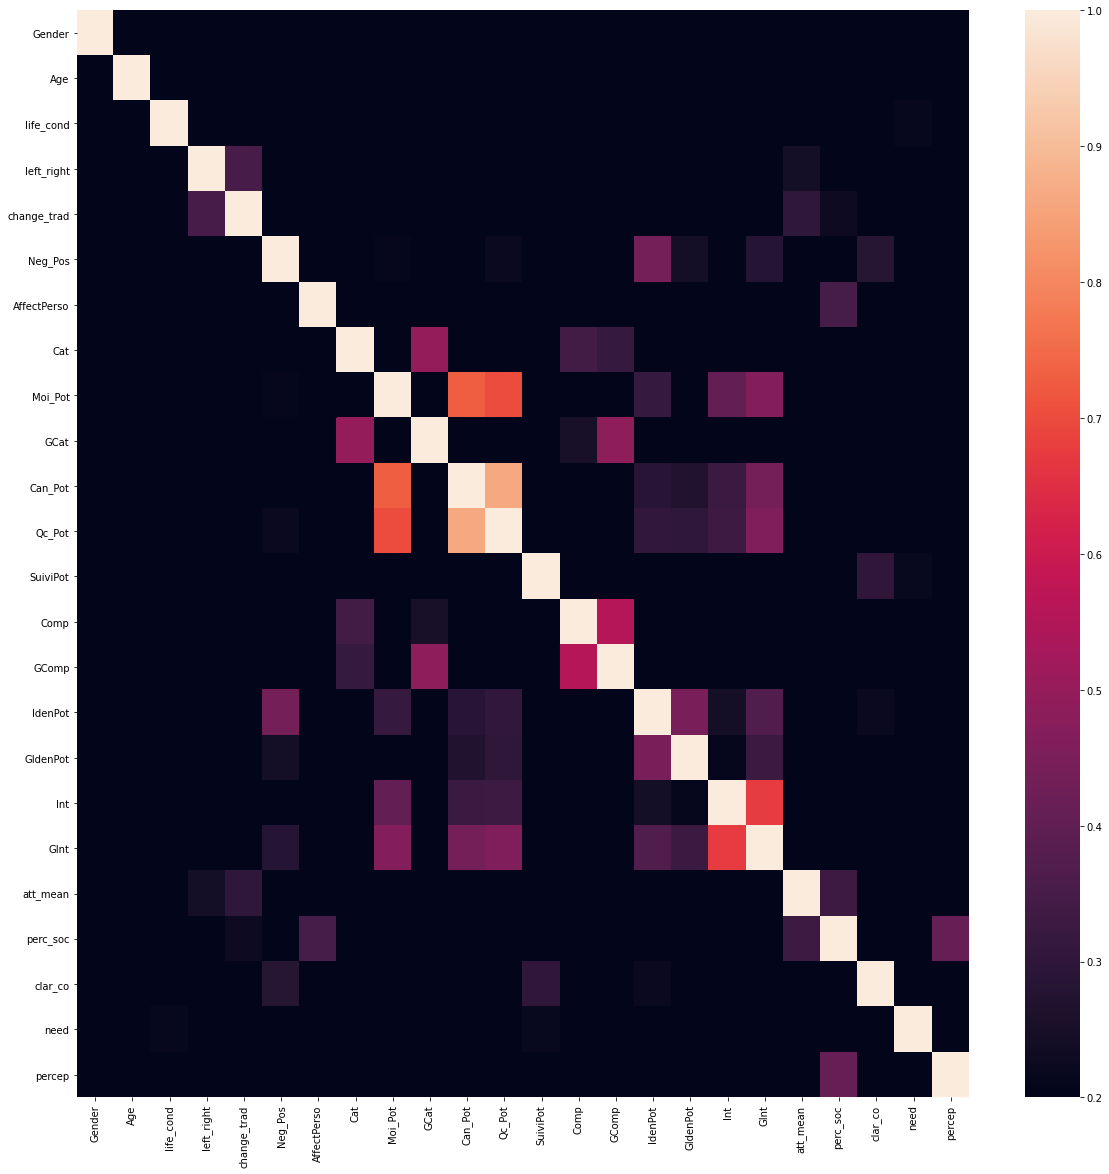

In [90]:
corr_matrix = df_T1.corr(method = 'pearson')

f, ax = plt.subplots(figsize=(20, 20))
ax = sn.heatmap(corr_matrix, annot = False, vmin=0.2, vmax=1.0)

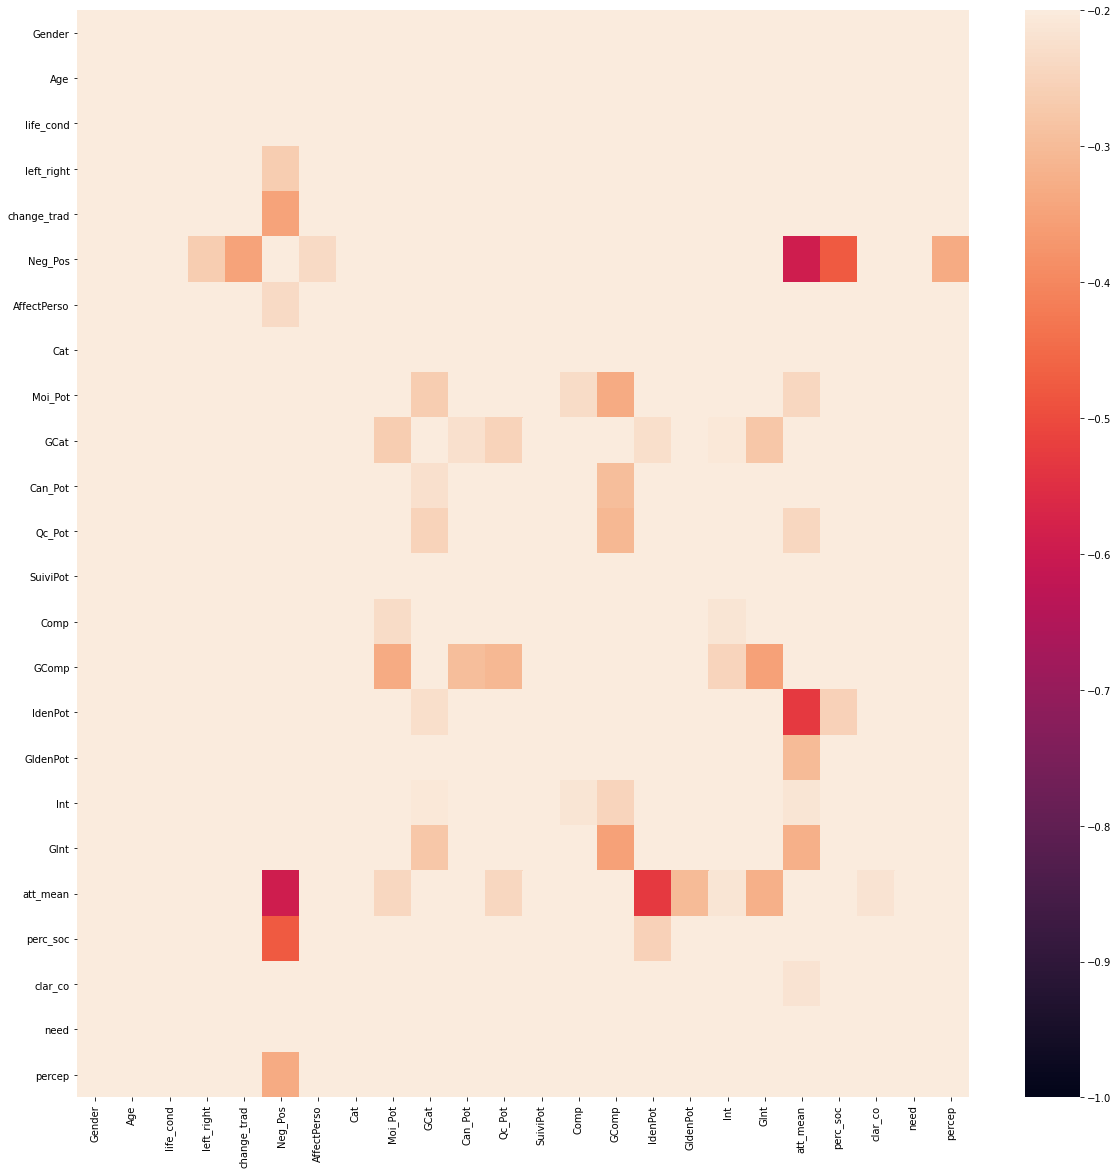

In [95]:
f, ax = plt.subplots(figsize=(20, 20))
ax = sn.heatmap(corr_matrix, annot = False, vmin=-1.0, vmax=-0.2)

In [92]:
#Check correlation values above 0.2 and below -0.2
#Access columns
df_corr = pd.DataFrame(columns=['Var1','Var2','Value'])
for i in range (len(corr_matrix)):
    #Access rows
    for j in range (len(corr_matrix)):
        if corr_matrix[corr_matrix.columns[i]][j] > 0.2 or corr_matrix[corr_matrix.columns[i]][j] < -0.2:
            if corr_matrix[corr_matrix.columns[i]][j] != 1:
                df_corr=df_corr.append({'Var1': corr_matrix.columns[i], 'Var2': corr_matrix.index[j], 'Value': corr_matrix[corr_matrix.columns[i]][j]}, ignore_index = True)

In [93]:
df_corr.to_csv('corr.csv', index=False)

<h2><b>Model Choice</h2></b>
<br>Variables included in the model: 
<li>UserBin : exogene</li>
<li>IdenPot : exogene</li>
<li>mean_att : endogene</li>
<li>Neg_pos : endogene</li>

In [ ]:
from PIL import Image
image = Image.open("")
image.show()

In [96]:
df_T1.columns

Index(['Gender', 'Age', 'life_cond', 'left_right', 'change_trad', 'Freqnow',
       'Userstatus', 'Legal', 'Illegal', 'Quantity', 'Frequency', 'Neg_Pos',
       'AffectPerso', 'Cat', 'Moi_Pot', 'GCat', 'Can_Pot', 'Qc_Pot',
       'SuiviPot', 'Comp', 'GComp', 'IdenPot', 'GIdenPot', 'Int', 'GInt',
       'UserBin', 'att_mean', 'perc_soc', 'clar_co', 'need', 'percep'],
      dtype='object')

In [97]:
#Create dataframe with the variables of interest
#Gender and Age only for the demographical data
df_model = df_T1.filter(items = ['Gender','Age','UserBin','IdenPot','Neg_Pos', 'att_mean'])

In [100]:
#Transform Gender into categorical variable
df_model['Gender'] = df_model['Gender'].astype("category")

<h3><b>Compute Cronbach's Alpha</b></h3>

<h3><b>Descriptive Stats</b></h3>
Including skewness and kurtosis

In [102]:
def add_skew_kurt_missing(dataframe = None):
    des1 = dataframe.describe(include='all')
    des2 = dataframe.isnull().sum().to_frame(name = 'missing').T
    des3 = dataframe.skew(axis=0,skipna=True).to_frame(name = 'skewness').T
    des4 = dataframe.kurtosis(axis=0,skipna=True).to_frame(name = 'kurtosis').T

    return pd.concat([des1, des2, des3, des4])

In [103]:
add_skew_kurt_missing(dataframe=df_model)

,Gender,Age,UserBin,IdenPot,Neg_Pos,att_mean
count,1657.0,1657.000000,1657.0,1657.000000,1657.000000,1657.000000
unique,2.0,NaN,2.0,NaN,NaN,NaN
top,1.0,NaN,0.0,NaN,NaN,NaN
freq,900.0,NaN,965.0,NaN,NaN,NaN
mean,NaN,50.905250,NaN,0.657614,1.786361,2.182257
std,NaN,15.376517,NaN,0.861823,1.206957,1.166972
min,NaN,18.000000,NaN,0.000000,0.000000,0.000000
25%,NaN,38.000000,NaN,0.000000,1.000000,1.333333
50%,NaN,52.000000,NaN,0.333333,2.000000,2.000000
75%,NaN,64.000000,NaN,1.000000,3.000000,3.000000


In [104]:
df_model = df_model.filter(items = ['UserBin','Neg_Pos','att_mean','IdenPot'])

<h3><b>Z scores (univariate outliers)</b></h3>

In [108]:
#Create an empty dataframe for zscores
df_zscores = pd.DataFrame(columns = df_model.columns)
#Calculate z scores(univariate outliers) for all variables
i=0
while i < len(df_model.columns):
    if df_model.columns[i] == df_zscores.columns[i]:
        df_zscores[df_zscores.columns[i]] = stats.zscore(df_model[df_model.columns[i]], nan_policy='omit')
        i+=1
    else:
        print('error')
        break

df_zscores.head(5)

,UserBin,Neg_Pos,att_mean,IdenPot
0,-0.846817,-1.48050,-0.727678,-0.763281
1,-0.846817,0.17706,0.986676,-0.763281
2,-0.846817,0.17706,-0.441952,-0.763281
3,1.180893,-0.65172,-0.727678,-0.763281
4,-0.846817,0.17706,-0.156227,1.558082


In [109]:
for i in range(len(df_zscores.columns)):
    v_min = df_zscores[df_zscores.columns[i]].min(skipna = True)
    v_max = df_zscores[df_zscores.columns[i]].max()
    print(df_zscores.columns[i], ": ", "min = ", v_min, " max = ", v_max)

UserBin :  min =  -0.8468166540614649  max =  1.180893166429644
Neg_Pos :  min =  -1.4804997530142  max =  1.834619288532461
att_mean :  min =  -1.870580944946523  max =  1.5581277118857653
IdenPot :  min =  -0.7632805792371932  max =  3.8794453423144577


<h3><b>Multivariate outliers</b></h3>
<br> Mahalanobis Distance: D^2 = (x-m)^T . C^(-1) . (x-m)
<br>
<br> D^2 := Square of the Mahalanobis distance
<br> x := vector of the observations
<br> m := vector of mean values of IV
<br> C^(-1) := inverse covariance matrix of IV
<br> . := dot product

In [110]:
#Calculate multivariate outliers (mahalanobis distance)
#https://www.machinelearningplus.com/statistics/mahalanobis-distance/

def mahalanobis_outliers(x=None, data=None, cov=None, dfreed=None, sign = None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov=np.cov(data.values.T)
    inv_covmat = scipy.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    data['mahal_square'] = np.power(md, 2)

    chi_critic = stats.chi2.ppf((1-sign), df = dfreed)

    ls_multioutliers = []

    for i in range (625):
        try:
            if data['mahal_square'][i] > chi_critic:
                ls_multioutliers.append(i+1)
        except:
            continue
    
    return data['mahal_square'], ls_multioutliers, chi_critic


col_mahal, ls_multiout, chi = mahalanobis_outliers(x = df_model.select_dtypes(exclude = 'category'), data = df_model.select_dtypes(exclude = 'category'), dfreed = len(df_model.select_dtypes(exclude = 'category').columns) - 1, sign = 0.001)
print('participants outliers: ', ls_multiout, '\nChi2 critique: ', chi)

participants outliers:  [16, 203, 287, 292, 575] 
Chi2 critique:  13.815510557964274


<h3>Bivariate relationship linearity</h3>

<b>IdentifyPot and Neg_Pos</b>

Text(0, 0.5, 'Régression Résiduel standardisé')

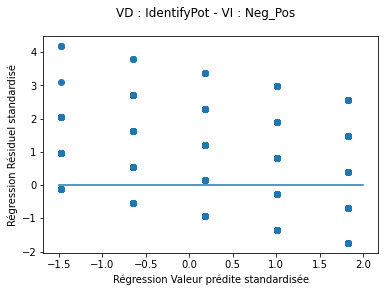

In [105]:
model1 = sm.OLS(df_tp['IdentifyPot'], sm.add_constant(df_tp['Neg_Pos'])).fit()
ypred1 = model1.predict()
standardized_yresid1 = preprocessing.scale(model1.resid)
standardized_ypred1 = preprocessing.scale(ypred1)
plt.scatter(standardized_ypred1, standardized_yresid1)
plt.plot([-1.5,2.0],[0,0])
plt.suptitle('VD : IdentifyPot - VI : Neg_Pos')
plt.xlabel('Régression Valeur prédite standardisée')
plt.ylabel('Régression Résiduel standardisé')

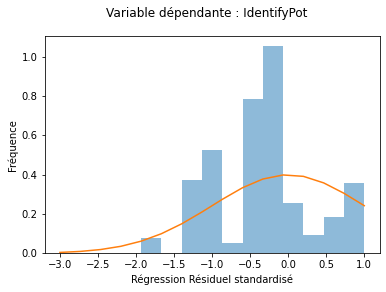

In [106]:
_, bins1, _ = plt.hist(standardized_yresid1, bins = 15, range=(-3,1), density = 1, alpha = 0.5)
mu1, sigma1 = stats.norm.fit(standardized_yresid1)
best_fit_line1 = stats.norm.pdf(bins1, mu1, sigma1)
plt.suptitle('Variable dépendante : IdentifyPot')
plt.xlabel('Régression Résiduel standardisé')
plt.ylabel('Fréquence')
plt.plot(bins1, best_fit_line1)

<b>IdentifyPot and average Attitude</b>

Text(0, 0.5, 'Régression Résiduel standardisé')

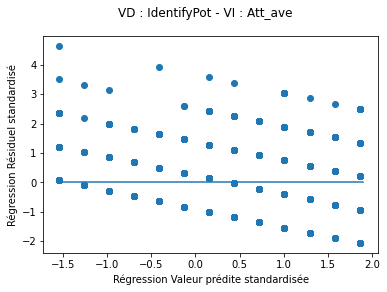

In [112]:
#Compute the scatter plot of the residuals

model2 = sm.OLS(df_tp['IdentifyPot'], sm.add_constant(df_tp['Att_ave'])).fit()
ypred2 = model2.predict()
standardized_yresid2 = preprocessing.scale(model2.resid)
standardized_ypred2 = preprocessing.scale(ypred2)
plt.scatter(standardized_ypred2, standardized_yresid2)
plt.plot([-1.53, 1.9],[0,0])
plt.suptitle('VD : IdentifyPot - VI : Att_ave')
plt.xlabel('Régression Valeur prédite standardisée')
plt.ylabel('Régression Résiduel standardisé')

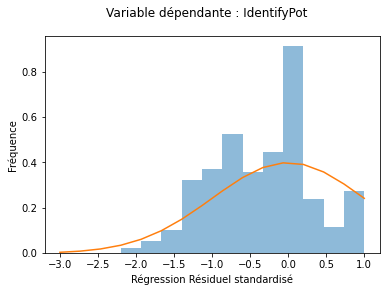

In [113]:
_, bins2, _ = plt.hist(standardized_yresid2, bins = 15, range=(-3,1), density = 1, alpha = 0.5)
mu2, sigma2 = stats.norm.fit(standardized_yresid2)
best_fit_line2 = stats.norm.pdf(bins2, mu2, sigma2)
plt.suptitle('Variable dépendante : IdentifyPot')
plt.xlabel('Régression Résiduel standardisé')
plt.ylabel('Fréquence')
plt.plot(bins2, best_fit_line2)

<b>Neg_Pos and average Attitude</b>

Text(0, 0.5, 'Régression Résiduel standardisé')

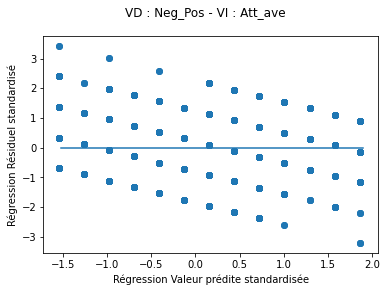

In [109]:
#Compute the scatter plot of the residuals

model3 = sm.OLS(df_tp['Neg_Pos'], sm.add_constant(df_tp['Att_ave'])).fit()
ypred3 = model3.predict()
standardized_yresid3 = preprocessing.scale(model3.resid)
standardized_ypred3 = preprocessing.scale(ypred3)
plt.scatter(standardized_ypred3, standardized_yresid3)
plt.plot([-1.53, 1.9],[0,0])
plt.suptitle('VD : Neg_Pos - VI : Att_ave')
plt.xlabel('Régression Valeur prédite standardisée')
plt.ylabel('Régression Résiduel standardisé')

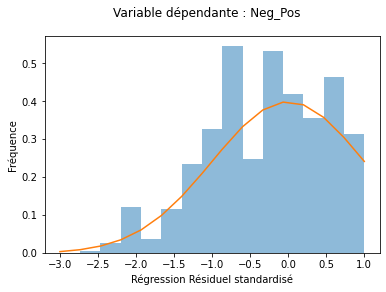

In [110]:
_, bins3, _ = plt.hist(standardized_yresid3, bins = 15, range=(-3,1), density = 1, alpha = 0.5)
mu3, sigma3 = stats.norm.fit(standardized_yresid3)
best_fit_line3 = stats.norm.pdf(bins3, mu3, sigma3)
plt.suptitle('Variable dépendante : Neg_Pos')
plt.xlabel('Régression Résiduel standardisé')
plt.ylabel('Fréquence')
plt.plot(bins3, best_fit_line3)